In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

## Interpolation in MetPy
There are a number of different interpolations that we might want to do to analyze meteorological data that go beyond what we would individually want to construct in our own code. MetPy offers a number of different interpolation functions depending on what you are attempting to accomplish including:
* `interpolate_to_grid`
* `interpolate_to_isolevel`
* `cross-section`
* `isentropic_interpolation` and `isentropic_interpolation_as_dataset`

Most of these interpolation functions are available in the interpolation portion of the MetPy module, but in this notebook we'll work with the `isentropic_interpolation_as_dataset`, which is available in the calc portion of the module since it is not strictly just a method to interpolate observations to a grid or compute a grid value at a point, but uses grided data and thermodynamic calculations to compute specific isentropic levels.

## GFS Data
We'll begin by accessing recent GFS model output, using the F00 time to compute some isentropic levels. This data is coming from the Unidata THREDDS server, which stores approximately two weeks of data on their server at any given time.

https://thredds.ucar.edu/thredds/

In [2]:
date = datetime(2022, 11, 3, 12)

ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/'
                     f'Global_0p5deg/GFS_Global_0p5deg_{date:%Y%m%d_%H}00.grib2')

## Subset GFS Data

Here we want to only keep around our needed data to simplify our overall dataset, both in terms of which variables we are keeping around and selecting only the needed lat/lon, and level data that we need to compute our isentropic levels over the CONUS.

To subset variables: use a list of variable names to keep only those variables in your new dataset subset.

To slice dimensions: use a dictionary to set up the slices for the named dimension variables to reduce the total amount of data needing to be downloaded.

In [5]:
# Subset dataset for only certain variables
# Temperature, RH, u and v wind components
ds_subset = ds[['Temperature_isobaric', 'Relative_humidity_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']]
ds_subset

<xarray.Dataset>
Dimensions:                       (time: 129, isobaric: 41, lat: 361, lon: 720)
Coordinates:
  * lat                           (lat) float32 90.0 89.5 89.0 ... -89.5 -90.0
  * lon                           (lon) float32 0.0 0.5 1.0 ... 359.0 359.5
    reftime                       datetime64[ns] 2022-11-03T12:00:00
  * time                          (time) datetime64[ns] 2022-11-03T12:00:00 ....
  * isobaric                      (isobaric) float32 1.0 2.0 ... 9.75e+04 1e+05
Data variables:
    Temperature_isobaric          (time, isobaric, lat, lon) float32 ...
    Relative_humidity_isobaric    (time, isobaric, lat, lon) float32 ...
    u-component_of_wind_isobaric  (time, isobaric, lat, lon) float32 ...
    v-component_of_wind_isobaric  (time, isobaric, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...
    EXTRA_DIMENSION.reftime:                                                 ...

In [6]:
subset = dict(lat=slice(60, 20), lon=slice(360-140, 360-50),
              time=date, vertical=slice(100, None))

tmpk = ds_subset.Temperature_isobaric.metpy.sel(subset)
relh = ds_subset.Relative_humidity_isobaric.metpy.sel(subset)
uwnd = ds_subset['u-component_of_wind_isobaric'].metpy.sel(subset)
vwnd = ds_subset['v-component_of_wind_isobaric'].metpy.sel(subset)

In [7]:
tmpk

<xarray.DataArray 'Temperature_isobaric' (isobaric: 33, lat: 81, lon: 181)>
[483813 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 60.0 59.5 59.0 58.5 58.0 ... 21.5 21.0 20.5 20.0
  * lon       (lon) float32 220.0 220.5 221.0 221.5 ... 308.5 309.0 309.5 310.0
    reftime   datetime64[ns] 2022-11-03T12:00:00
    time      datetime64[ns] 2022-11-03T12:00:00
  * isobaric  (isobaric) float32 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
Attributes:
    long_name:                       Temperature @ Isobaric surface
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_0-0-0_L100
    Grib2_Parameter:                 [0 0 0]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                100
    Grib2_Level_Desc:                Isobaric surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

## Interpolation to Isentropic Levels
In order to do our interpolation, we'll need to feed our function with the levels we want to compute. A list of values containing one or more isentropic (potential temperature) levels are needed with appropriate units attached. Here we'll set up a NumPy array of values from 285 K to 325 K to feed into our interpolation function.

Using the `isentropic_interpolation_as_dataset` function gives us back a nicely formated xarray Dataset object that will work just like the original GFS dataset that was read in using xarray. This will make our plotting easier in the end. Additionally, there are two required arguments (the isentropic levels and the temperature array), but additional variables can be included for interpolation to the same levels. We'll add relative humidity and the wind components so we can plot all of it on our map.

More information at https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation_as_dataset.html

In [8]:
# define isentropic levels desired
levs = np.arange(285, 326, 3) * units.K
isent = mpcalc.isentropic_interpolation_as_dataset(levs, tmpk, relh, uwnd, vwnd)

/Users/kgoebber/miniconda3/envs/main/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/Users/kgoebber/miniconda3/envs/main/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:157: RuntimeWarning: divide by zero encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])


In [9]:
isent

Magnitude,[[[709.7463989257812 702.5970458984375 722.0128173828125 ... 800.1295776367188 807.6021728515625 816.9567260742188] [703.6397705078125 697.2640380859375 686.6220092773438 ... 808.0685424804688 818.0982055664062 825.708984375] [690.0016479492188 690.5906372070312 687.34912109375 ... 812.9523315429688 823.82373046875 829.9849243164062] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[575.5172119140625 577.7273559570312 573.5341186523438 ... 729.876220703125 739.7168579101562 744.976806640625] [582.0601196289062 572.265869140625 561.23974609375 ... 739.804443359375 748.4849853515625 760.3201904296875] [580.0643310546875 574.8635864257812 567.8788452148438 ... 747.0615844726562 756.34130859375 770.326416015625] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[477.0669250488281 474.97760009765625 487.009033203125 ... 673.501220703125 679.554443359375 681.16650390625] [498.1322326660156 495.32330322265625 491.3643798828125 ... 682.4733276367188 692.1157836914062 698.520263671875] [531.4611206054688 529.03271484375 526.5662231445312 ... 691.3785400390625 698.6536865234375 708.0596313476562] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] ... [[327.783935546875 330.18695068359375 328.9070739746094 ... 278.7598876953125 277.1955871582031 277.2903137207031] [329.826904296875 330.6508483886719 333.5317077636719 ... 280.6292724609375 279.6892395019531 279.67138671875] [332.18951416015625 332.3467712402344 332.7979431152344 ... 284.0710144042969 282.95037841796875 283.04962158203125] ... [566.6835327148438 568.5232543945312 567.8517456054688 ... 543.7708129882812 547.1370239257812 548.970458984375] [569.3595581054688 569.6173095703125 570.5983276367188 ... 543.2889404296875 548.0240478515625 548.1071166992188] [568.0711059570312 568.018310546875 570.6204223632812 ... 553.9396362304688 548.7825317382812 544.4400634765625]] [[311.4009094238281 313.89788818359375 311.8092041015625 ... 272.776123046875 271.3119812011719 271.2659606933594] [313.3824768066406 314.1470642089844 316.90655517578125 ... 274.859375 274.37799072265625 274.3764343261719] [307.3241882324219 307.53057861328125 309.2410888671875 ... 278.3375549316406 277.5671691894531 277.7620849609375] ... [531.6369018554688 535.180908203125 534.05712890625 ... 501.41827392578125 505.459228515625 511.6712951660156] [534.7969360351562 536.635009765625 538.824951171875 ... 496.9933776855469 512.8931274414062 514.4326782226562] [531.0703735351562 533.9259033203125 539.7362670898438 ... 515.5867919921875 514.72412109375 511.1925964355469]] [[297.010009765625 298.8915100097656 296.9924621582031 ... 266.9685363769531 265.5999450683594 265.4208068847656] [298.3775939941406 298.9039611816406 301.2088623046875 ... 269.2531433105469 269.20733642578125 269.22125244140625] [292.04168701171875 292.42730712890625 293.46331787109375 ... 272.76416015625 272.3266906738281 272.61248779296875] ... [489.1262512207031 493.5393981933594 494.2796630859375 ... 469.8294372558594 469.60565185546875 473.3939514160156] [491.5304260253906 493.3992919921875 500.51800537109375 ... 469.9416198730469 467.3622741699219 476.66156005859375] [491.2922668457031 494.06488037109375 502.4056701660156 ... 472.2164001464844 474.25732421875 475.27264404296875]]]
Units,hectopascal
Magnitude,[[[258.40620524239347 257.65978737802334 259.67438836894945 ... 267.40923506019675 268.1203797451887 269.00407587170366] [257.7689931524056 257.09949368433524 255.97217955876377 ... 268.1646191439495 269.1114185593928 269.8243489068108] [256.331541757994 256.39402659308865 256.0495984233171 ... 268.62668049452185 269.6482030508243 270.2228330775126] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[245.9448389149886 246.21433838891346 245.70241349683667 ... 263.22119045115727 264.23031855693915 264.765772968241] [246.74049629182372 245.5470596635303

## Plotting an Isentropic Map
This is the same as plotting any other variable, except that we'll use the data from our interpolation instead. One of the first things we'll have to do is pull out the data for the level we want to plot (e.g., 303 K) and then proceed to use contours, colorfills, and wind barbs to plot all of the information we desire.

In [26]:
# Set desired level and subset data accordingly; smooth some fields
level = 300 * units.K
isent_pres = mpcalc.smooth_n_point(isent.pressure.sel(isentropic_level=level), 9, 3)
isent_relh = mpcalc.smooth_n_point(isent.Relative_humidity_isobaric.sel(isentropic_level=level), 9, 3)
isent_uwnd = isent['u-component_of_wind_isobaric'].sel(isentropic_level=level,
                                                       lat=slice(None, None, 5), lon=slice(None, None, 5)).metpy.convert_units('kt')
isent_vwnd = isent['v-component_of_wind_isobaric'].sel(isentropic_level=level,
                                                       lat=slice(None, None, 5), lon=slice(None, None, 5)).metpy.convert_units('kt')

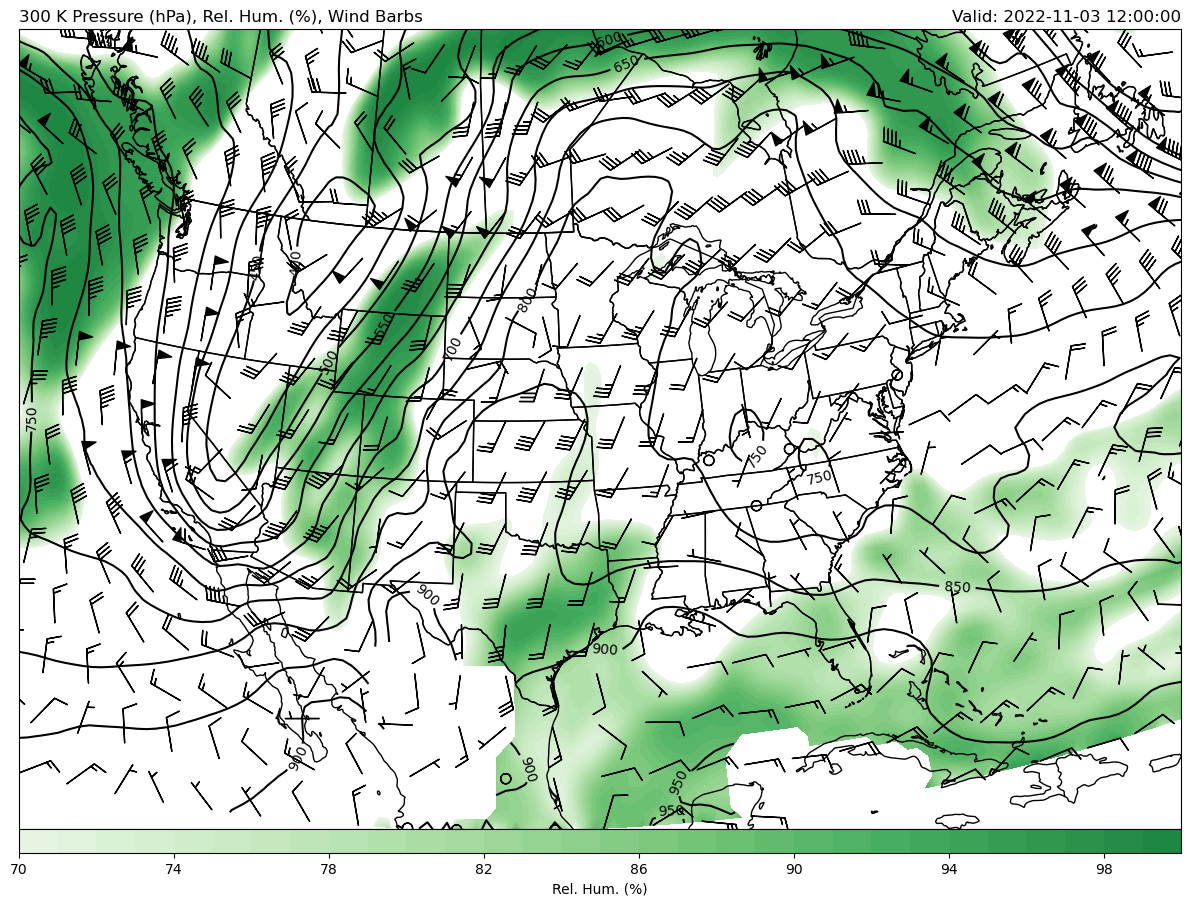

In [27]:
# Isentropic Map
plt.figure(1, figsize=(15, 13))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-100, standard_parallels=(25, 40)))
ax.set_extent([-125, -65, 20, 55], ccrs.PlateCarree())

# Contour Isentropic Level Pressure in black
cs = ax.contour(isent.lon, isent.lat, isent_pres, np.arange(0, 1000, 50),
                colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs)

# Colorfill Isentropic Level Relative Humidity in Greens
cf = ax.contourf(isent.lon, isent.lat, isent_relh, np.arange(70, 101, 1),
                 cmap=plt.cm.Greens, norm=plt.Normalize(65, 110), transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, label='Rel. Hum. (%)')

# Add Isentropic Level wind barbs in knots
ax.barbs(isent_uwnd.lon, isent_uwnd.lat, isent_uwnd.data, isent_vwnd.data, length=7,
         transform=ccrs.PlateCarree())

# Add Geographic Features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Add titles
plt.title(f'{level.m} K Pressure (hPa), Rel. Hum. (%), Wind Barbs', loc='left')
plt.title(f'Valid: {date}', loc='right')

plt.show()